In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Dimensionality Reduction and Clustering
In this homework, we will be working with MNIST data which consists of hand-drawn numerical digits, zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive. Our goal will be to get a handle on the dimensionality of the data and then perform clustering analysis.

In [2]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata

In [3]:
mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

## PCA
We first will use Principal Component Analysis to reduce the dimensionality of the data. Our first step here will be deciding how much to reduce the dimensionality. Let's plot how the ratio of explained variance changes as we keep more and more dimensions of the data. What we are looking for is an 'elbow,' or a place in the data where the amount of variation in the data begins to increase less and less as we include more components.

Text(0,0.5,'Ratio of Explained Variance')

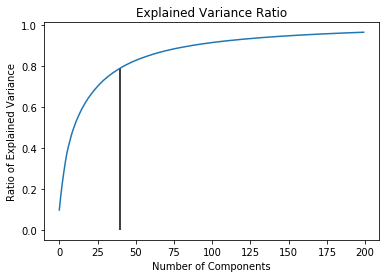

In [4]:
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[40],x=40)
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Explained Variance')

We see this elbow at 40 components. I will reduce the dimension down to 40, and then plot the first two components.

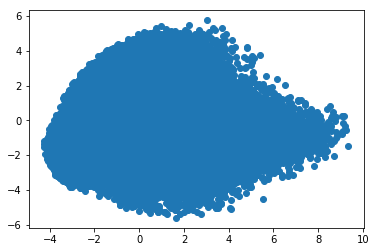

In [5]:
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1])

It seems that the first component is most dense at the low end of the spectrum, and the second is more equally spread. This plot is showing us how spread out the data are in the two main projections.

Generally, you want to use PCA when you have too many features for the problem to be tractable. More features means more variance in your data, and you open yourself up to overfitting. PCA lets you pick the most important combinations of features. But, you lose a lot of intuition when you do that. For example, with this letter data set, these two principle components barely have an interpretation - they are the two combinations of features (pixel-values) that include the highest variance possible and are orthogonal to each other.

In this particular problem, intuition for the features isn't as important. But, if you were trying to predict house prices, you would want to know what features of a house are most important.

Let's plot an image, and then compress it using PCA, undo the transformation, and replot it.

Text(0.5,1,'One handwritten digit')

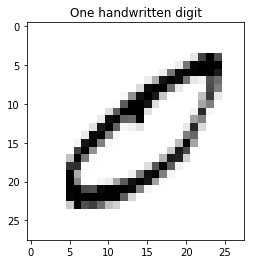

In [6]:
plt.imshow(X[101].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title('One handwritten digit')

In [7]:
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)
compressed_X = pca.inverse_transform(X_pca)

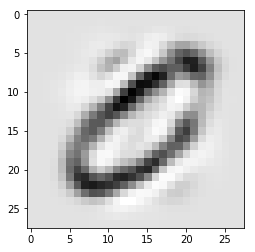

In [8]:
plt.imshow(compressed_X[101].reshape((28,28)), cmap='Greys')

Sort of interesting what it looks like. It's definitely the same image, but you can see that some of the clarity has been lost. It's a lot more blurry. If I were to play around with the number of components, I could get it to be sharper (more components) or more blurry (fewer components). As is, I am losing about 20% of the data in this compression.

## t-SNE
Let's use t-SNE to have a look at the data. I will be using an implementation of t-SNE which I found on GitHub, which runs much faster than the sklearn t-SNE. Credit to https://github.com/DmitryUlyanov/Multicore-TSNE

In [9]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [10]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200, n_jobs=3)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

Text(0.5,1,'T-SNE Visualization')

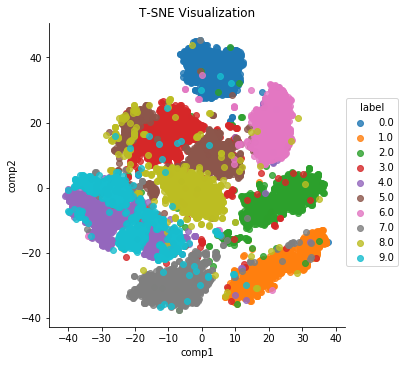

In [11]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
ax = plt.gca()
ax.set_title('T-SNE Visualization')

I now define a function that will make it easy to play around with the t-SNE hyper parameters and visualize my results:

In [12]:
def plot(data, perplexity, n_iter, learning_rate):
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=n_iter, learning_rate=learning_rate, n_jobs=3)
    tsne_results = tsne.fit_transform(data[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

Let's see how robust t-SNE is to changes in the perplexity:

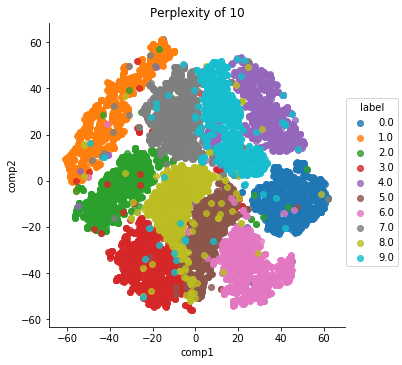

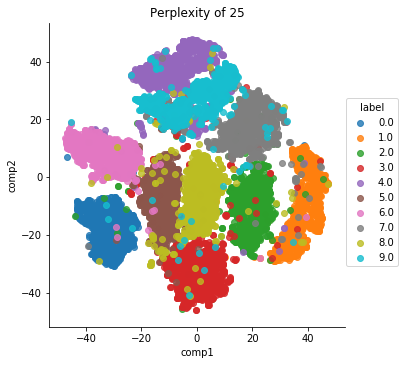

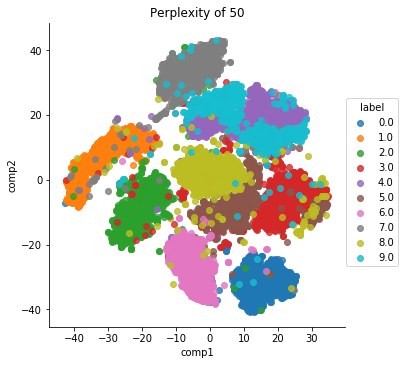

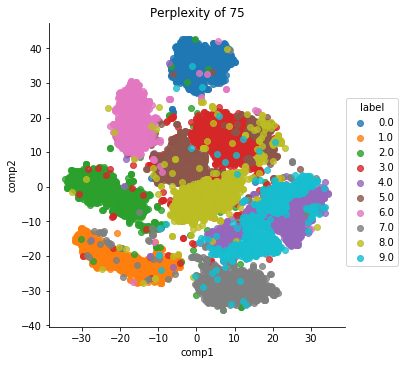

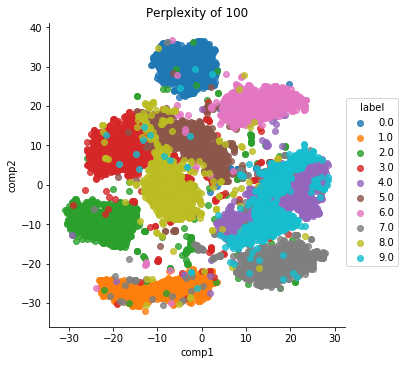

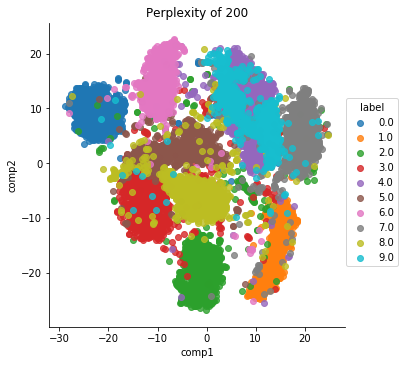

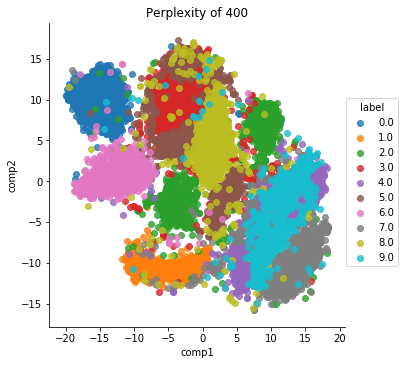

In [13]:
perplexities = [10, 25, 50, 75, 100, 200, 400]
for perplexity in perplexities:
    plot(X_pca, perplexity, 1000, 200)
    ax = plt.gca()
    ax.set_title('Perplexity of ' + str(perplexity))

Now, let's see what happens if we tweak the number of iterations and the learning rate:

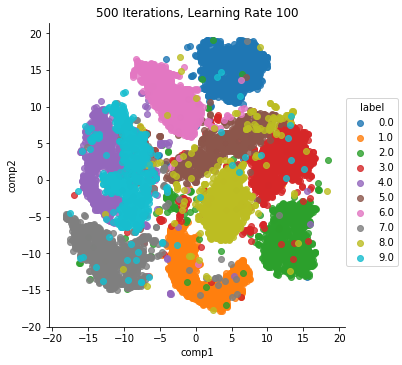

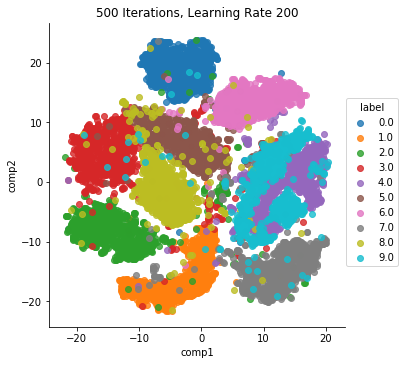

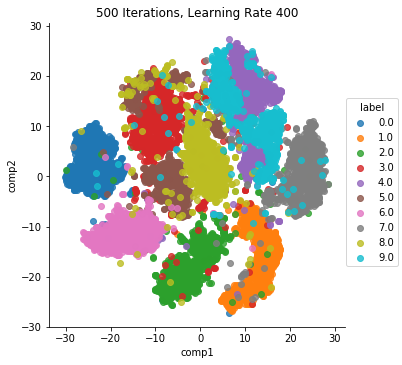

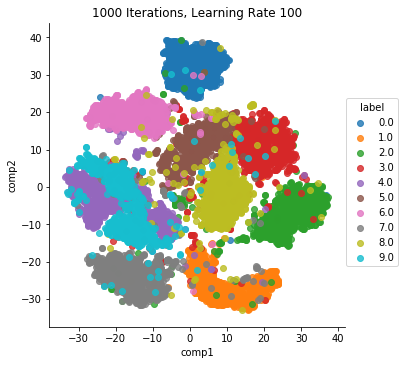

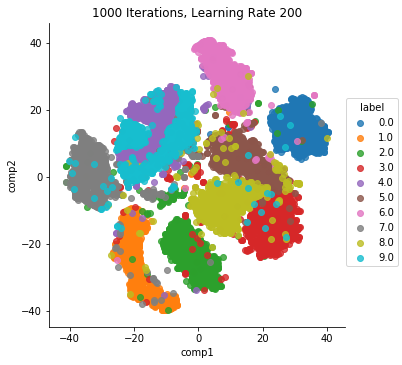

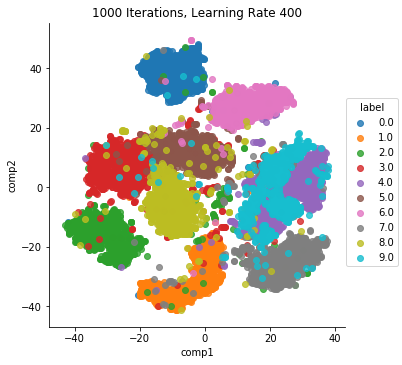

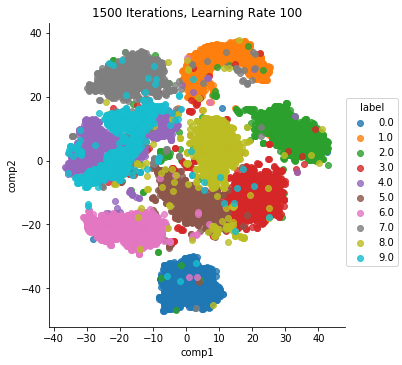

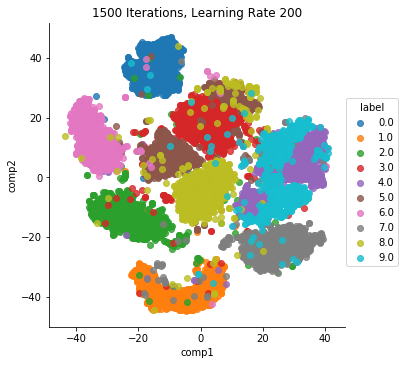

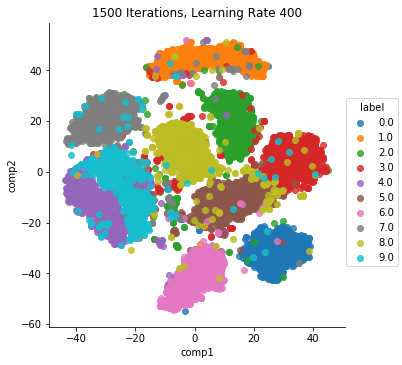

In [14]:
iterations = [500, 1000, 1500]
learningrates = [100, 200, 400]
for iteration in iterations:
    for lrate in learningrates:
        plot(X_pca, 50, iteration, lrate)
        ax = plt.gca()
        ax.set_title(str(iteration)+' Iterations, Learning Rate ' + str(lrate))

Playing around with the perplexity level doesn't do too much until we put it up too far. It seems that the algorithm fails to converge with a perplexity level that is 'too high.'

It seems like t-SNE is pretty robust to changes in iterations. Although, if I lower the iteration count too much, we see that the algortihm fails to converge and we don't see nice clusters like we would want. The learning rate changes the positioning of the clusters, but not their quality or separation. However, absolute positioning of the clusters means nothing in t-SNE.

## K-means Clustering
Now, we will use the K-means clustering algorithm for yet another way of visualizing how the data may be grouped into separate groups. We hope that the clusters in the data correspond with the 10 distinct digits the data ought to represent; thus, we will use 10 as our choice for the hyperparameter k.

Scaling the data is a bad thing if our features have some sort of intuitive meaning. However, the data in this case just correspond to a pixel's position and darkness. I will scale the data without worrying about losing an interpretation of distance.

To save on computing power, we will again randomly select 10,0000 observations.

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [16]:
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(X[rows[:n_select],:])
sk_clusters = kmeans.predict(X)
#About 30 seconds for 10,000

Let's visualize our data with t-SNE and see how well the clustering worked.

In [17]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, learning_rate=200, n_jobs=3)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

Text(0.5,1,'T-SNE Visualization')

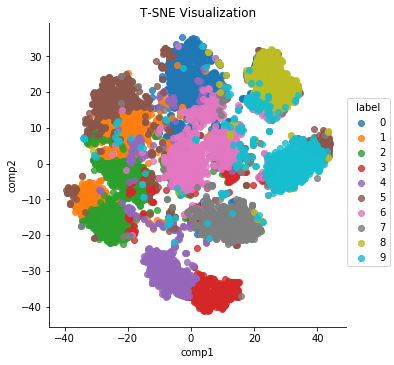

In [18]:
cluster_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
cluster_tsne['label'] = sk_clusters[rows[:n_select]]
sns.lmplot(x='comp1', y='comp2', data=cluster_tsne, hue='label', fit_reg=False)
ax = plt.gca()
ax.set_title('T-SNE Visualization')

In [19]:
print(silhouette_score(cluster_tsne[['comp1', 'comp2']], sk_clusters[rows[:n_select]], metric='euclidean'))

0.174121238042


Decent. Good enough for government work. Let's try a few different clustering hyperparameters to see how robust it is. We will also evaluate each clustering using its silhouette score and the euclidean metric.

In [20]:
def clusterplot(cluster_tsne, n_init):
    kmeans = KMeans(n_clusters=10, n_init=n_init, n_jobs=-1)
    kmeans.fit(X[rows[:n_select],:])
    sk_clusters = kmeans.predict(X)
    cluster_tsne['label'] = sk_clusters[rows[:n_select]]
    print('Silhouette Score of ' + str(silhouette_score(cluster_tsne[['comp1', 'comp2']], sk_clusters[rows[:n_select]], metric='euclidean'))+ ' for n_init of ' + str(n_init))
    sns.lmplot(x='comp1', y='comp2', data=cluster_tsne, hue='label', fit_reg=False)

Silhouette Score of 0.193536188813 for n_init of 1
Silhouette Score of 0.174037956883 for n_init of 5
Silhouette Score of 0.173816576806 for n_init of 25
Silhouette Score of 0.17582647075 for n_init of 75


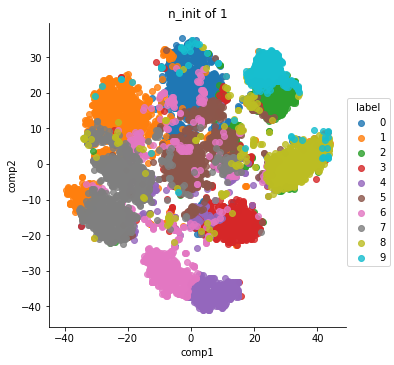

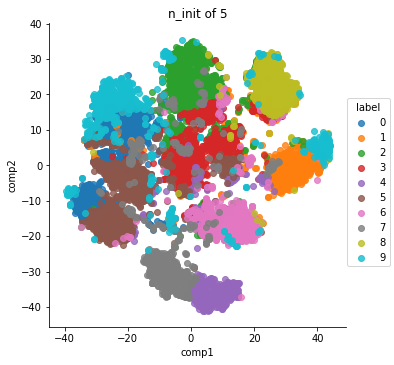

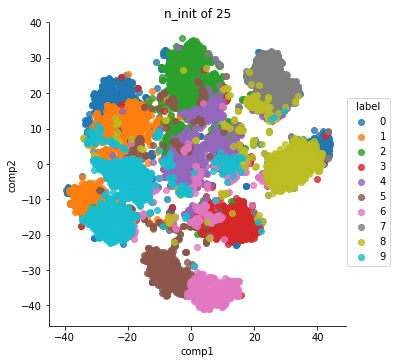

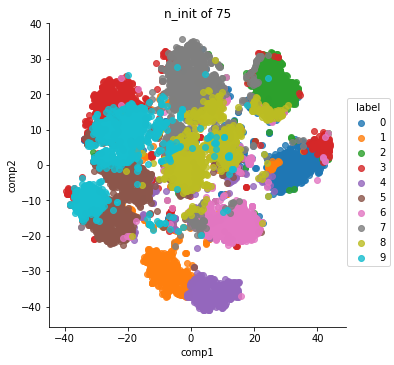

In [21]:
numinit = [1, 5, 25, 75]
for num in numinit:
    clusterplot(cluster_tsne, num)
    ax = plt.gca()
    ax.set_title('n_init of ' + str(num))

The clustering seems fairly robust to changes in this hyperparameter.

Let's see what happens if we do clustering on different subsets of the data. I will perform clustering on 3 random subsets of the data, and then visualize each cluster using t-SNE. I will also view that same random subset of the data labeled correctly, and see how we measure up.

Silhouette Score of 0.182014443157 for n_init of 50
Silhouette Score of 0.205997116688 for n_init of 50
Silhouette Score of 0.2063596826 for n_init of 50


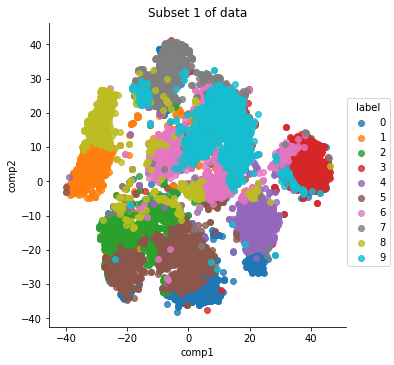

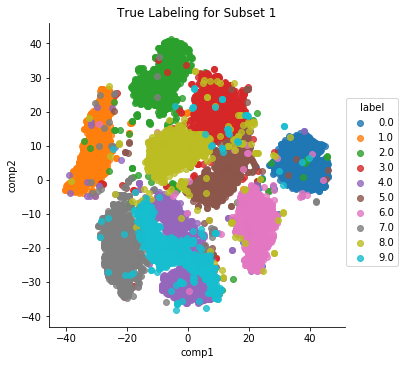

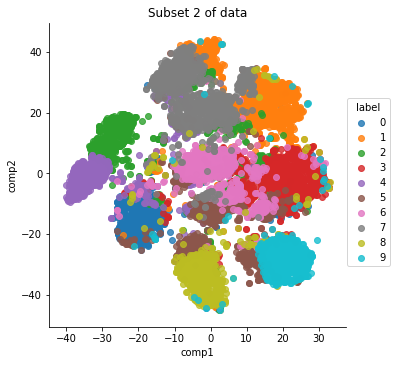

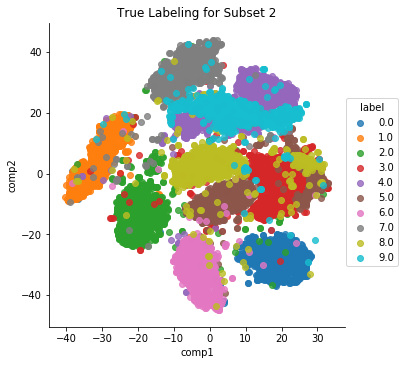

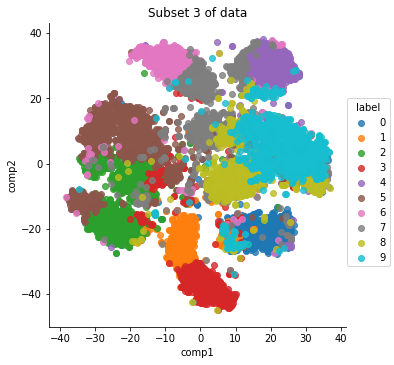

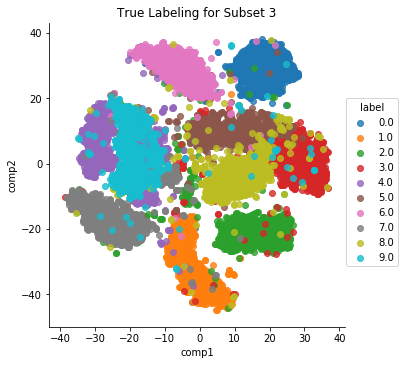

In [35]:
n_select=10000
for i in range(1,4):
    np.random.seed(seed=i)
    rows = np.arange(70000)
    np.random.shuffle(rows)
    tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, learning_rate=200, n_jobs=3)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    cluster_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    clusterplot(cluster_tsne, 50)
    ax1 = plt.gca()
    ax1.set_title('Subset ' + str(i) + ' of data')
    cluster_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=cluster_tsne, hue='label', fit_reg=False)
    ax2 = plt.gca()
    ax2.set_title('True Labeling for Subset ' + str(i))

So, the subset of the data on which we start is very important, as it turns out. It's also nice to see how the clustering compares to the true labeling. It seems that clustering is getting a lot right, but it is also splitting where I wouldn't like it to. The visual clusters that t-SNE produces correspond a lot more closely to the actual labels.
## Hierarchical Clustering
Let's try another type of clustering. We will use scikit-learn's built-in hierarchical clustering functionality.

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage

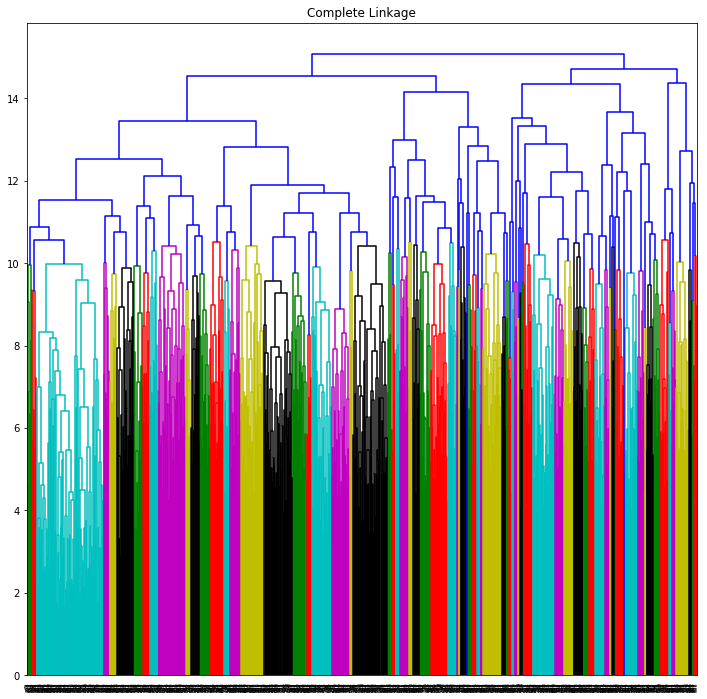

In [24]:
n_select=1000
Z = linkage(X[rows[:n_select]], 'complete')
plt.figure(figsize=(12, 12))
plt.title('Complete Linkage')
_ = dendrogram(Z)

I would actually choose about 7 clusters based on the graph. I can see why choosing the number of clusters is sort of an art.

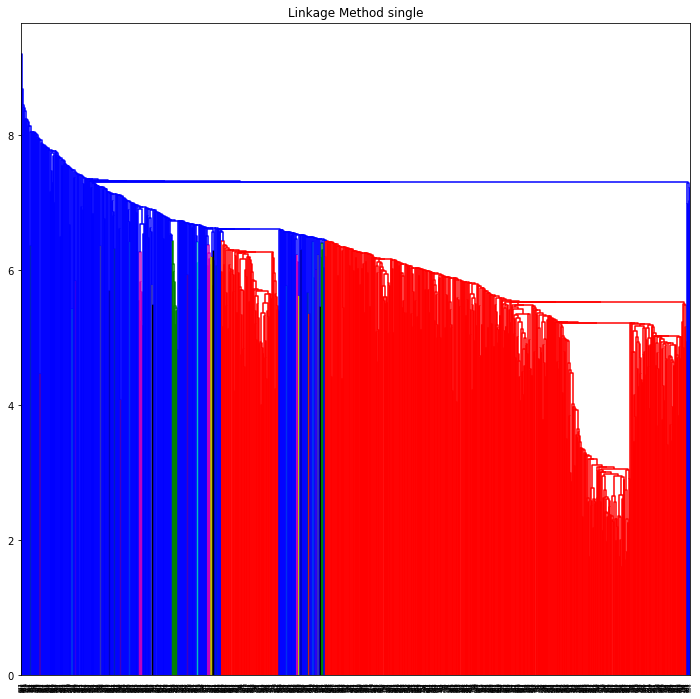

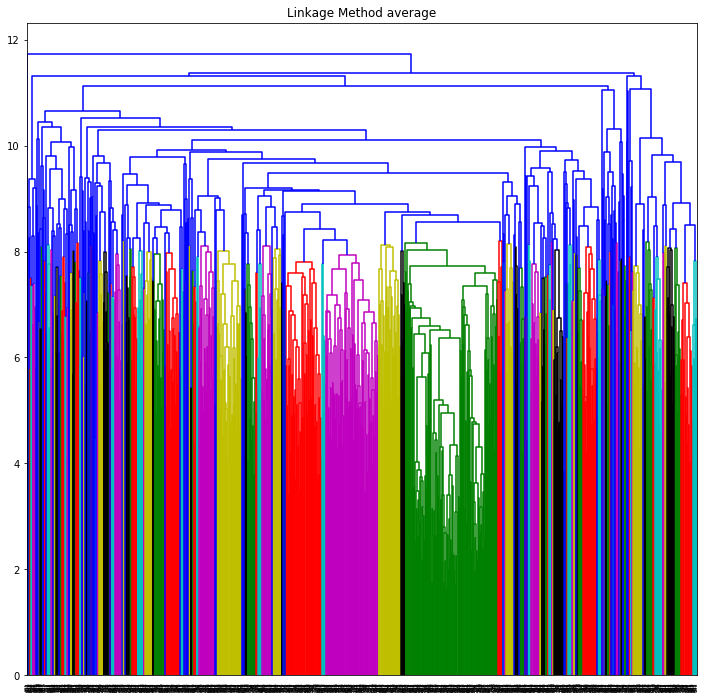

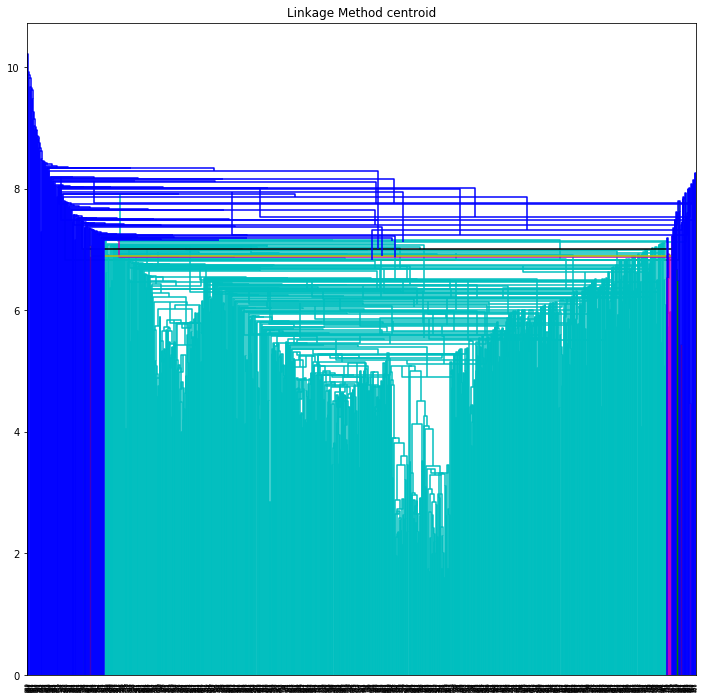

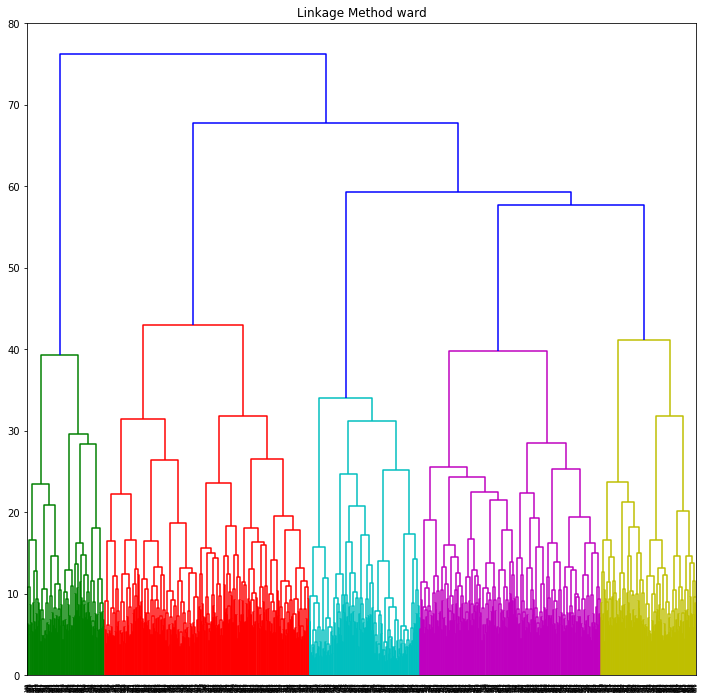

In [25]:
linkage_methods = ['single', 'average', 'centroid', 'ward']
for method in linkage_methods:
    Z = linkage(X[rows[:n_select]], method)
    plt.figure(figsize=(12, 12))
    plt.title('Linkage Method ' + method)
    _ = dendrogram(Z)

I think that the 'ward' linkage method is clearest here.